<a href="https://colab.research.google.com/github/Tuan164/DGA/blob/main/Domain_Classifier_Model_50_25_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 6.1 kB/s 
     |████████████████████████████████| 1.6 MB 46.8 MB/s 
     |████████████████████████████████| 438 kB 73.8 MB/s 
     |████████████████████████████████| 5.8 MB 44.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.

In [22]:
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sn

from tensorflow.keras.layers import Input, LSTM, Dropout, Embedding, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix



In [23]:
def load_tf_dataset(domains):
  vocab = sorted(set(''.join(domains['domain'].to_list())))
  char2idx = {u:i for i, u in enumerate(vocab)}
  idx2char = np.array(vocab)

  lines = []
  for i, line in enumerate(domains.iloc[:, 0]):
    lines.append([char2idx[c] for c in line])
  
  tensor = tf.keras.preprocessing.sequence.pad_sequences(lines, padding='post')
  targets = np.array(domains.iloc[:, 1], dtype=np.int32)

  data = tf.data.Dataset.from_tensor_slices(tensor)
  pred = tf.data.Dataset.from_tensor_slices(targets)
  dataset = tf.data.Dataset.zip((data, pred))
  
  return dataset, (char2idx, idx2char)

In [24]:
domains = pd.read_csv('https://raw.githubusercontent.com/Tuan164/DGA/main/DGA.csv')

In [25]:
domains

,domain,pred
0,3yb2tozybacr.com,1
1,lyceelbv.org,0
2,3tc5ib9n3wcixq.com,1
3,alstedefarms.com,0
4,wkrbi2ihkkmfm55.com,1
...,...,...
1994855,lx1gu31kn1ph.net,1
1994856,5qba2ygkxcq.net,1
1994857,rskzzhwywv5t.net,1
1994858,printwhatyoulike.com,0


We will use the first 1.5 million domains for training, and the remaining ones will be left for testing, inference, etc. The domains were already shuffled when the dataset was created, so we only need to batch them.

In [54]:
dataset, mappings = load_tf_dataset(domains[:997430])
validation_dataset, _ = load_tf_dataset(domains[997430:1496145])
test_dataset = list(domains[1496145:]["domain"])
char2idx, idx2char = mappings

In [55]:
dataset = dataset.batch(1500, drop_remainder=True)

In [56]:
validation_dataset = validation_dataset.batch(1500, drop_remainder=True)

### Building the Model

Here, we build the model using Tensorflow's Keras API. It uses an architecture adapted from B. Yu *et al.*, 2018, which first embeds each character as a 128-dimensional vector, passes it through a 1D convolutional layer, runs it through an LSTM, and classifies it with a single dense layer.

The 82 in the input dimension comes from the fact that the maximum domain length in the training data is 82 characters, and the 39 comes from the 38 possible characters in a domain name.

We train the model for 20 epochs, using Adam.

In [29]:
def create_model():
  domain_input = Input(shape=(73,), dtype='int32', name='domain_input')
  embedding = Embedding(input_dim=39, output_dim=128, input_length=73, 
                        batch_input_shape=[1500, None])(domain_input)
  conv = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', strides=1)(embedding)
  pool = MaxPooling1D(pool_size=2, padding='same')(conv)
  lstm = LSTM(64, return_sequences=False)(pool)
  drop = Dropout(0.5)(lstm)
  output = Dense(1, activation='sigmoid')(drop)
  model = tf.keras.Model(inputs=domain_input, outputs=output)
  return model

In [30]:
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 domain_input (InputLayer)   [(None, 73)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 73, 128)           4992      
                                                                 
 conv1d_1 (Conv1D)           (None, 73, 128)           49280     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 37, 128)          0         
 1D)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                           

In [57]:
EPOCHS = 6 
accuracy = []
losses = []

for i in range(EPOCHS):
  history = model.fit(dataset, validation_data=validation_dataset)

  accuracy.append(history.history['accuracy'])
  losses.append(history.history['loss'])

# Training was originally run for 8 epochs, but was stopped at only 6 epochs, due to time constraints.

664/664 [==============================] - 27s 41ms/step - loss: 0.0066 - accuracy: 0.9980 - val_loss: 0.0072 - val_accuracy: 0.9980


In [58]:
CHAR2IDX = {'-': 0, '.': 1, '0': 2, '1': 3, '2': 4, '3': 5,
            '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11,
            '_': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17,
            'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'k': 23,
            'l': 24, 'm': 25, 'n': 26, 'o': 27, 'p': 28, 'q': 29,
            'r': 30, 's': 31, 't': 32, 'u': 33, 'v': 34, 'w': 35,
            'x': 36, 'y': 37, 'z': 38}

def _inputs(domains):
    if isinstance(domains, list):
        return [domain.lower() for domain in domains]

    return [domains.lower()]

def get_prob(domains, raw=False, internal=False):
    if not isinstance(domains, list):
        domains = _inputs(domains)

    vec = np.zeros((len(domains), 73))

    for i, domain in enumerate(domains):
        for j, char in enumerate(domain):
            vec[i, j] = CHAR2IDX[char] if char in CHAR2IDX else -1
    return vec

predict_data = get_prob(test_dataset)


In [59]:
y_true = domains[1496145:]["pred"]
y_pred = model.predict(predict_data)
for i, prob in enumerate(y_pred):
  y_pred[i] = (prob >= 0.5)


In [61]:
# cm = confusion_matrix(list(y_true), list(y_pred), labels=[0, 1]).ravel()
tn, fp, fn, tp = confusion_matrix(list(y_true), list(y_pred), labels=[0, 1]).ravel()

tot = tn+tp+fp+fn

tpr = tp/tot * 100
tnr = tn/tot * 100
fpr = fp/tot * 100
fnr = fn/tot * 100

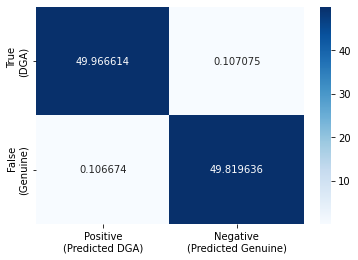

In [62]:
cm_data = [[tpr, fnr], [fpr, tnr]]
x_label, y_label = ["Positive\n(Predicted DGA)", "Negative\n(Predicted Genuine)"], ["True\n(DGA)", "False\n(Genuine)"] 
sn.heatmap(cm_data, annot=True, cmap='Blues', fmt='f', xticklabels=x_label, yticklabels=y_label)

In [63]:
tf.keras.models.save_model(
    model,
    "trained_model_50_25_25.h5",
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)